exp

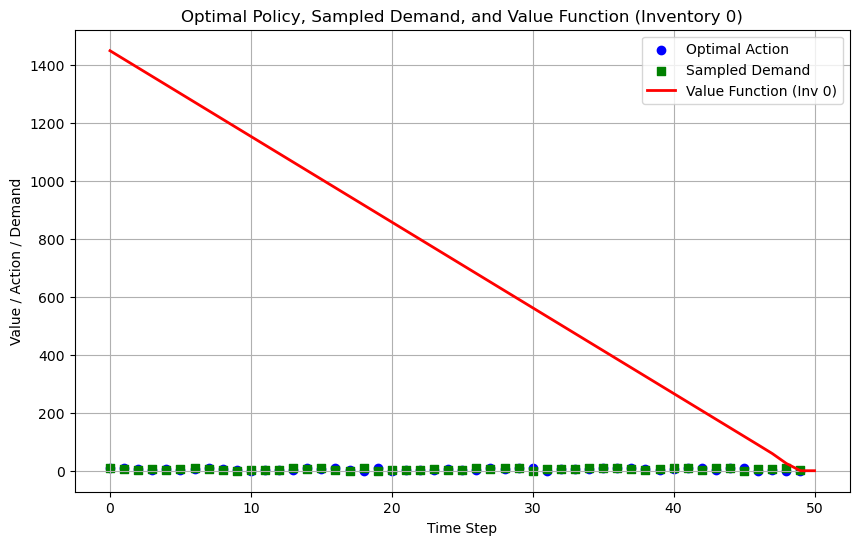

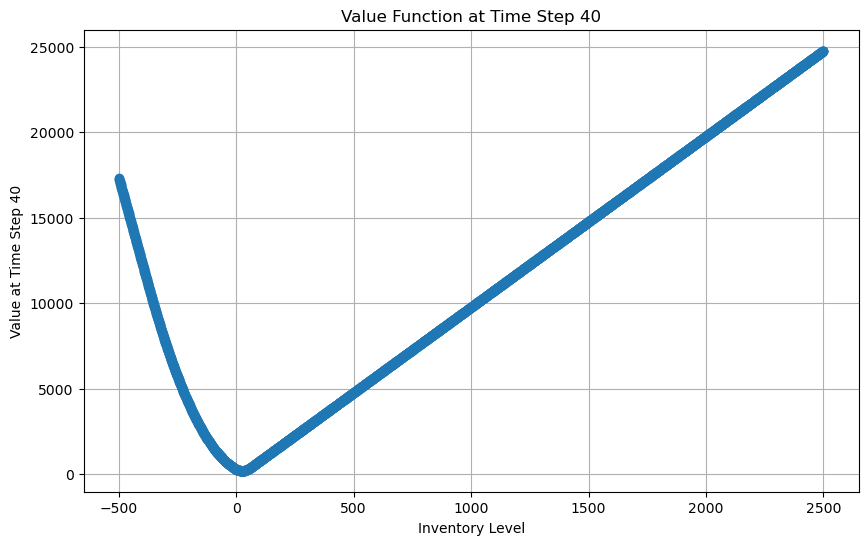

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Define ValueIteration Class (Using Expectation over Demand)
# ---------------------------
class ValueIteration:
    def __init__(self, num_states, actions, rewards, time_steps, discount=1.0, 
                 min_inventory=-500, max_inventory=200):
        self.num_states = num_states  # number of states
        self.actions = actions        # number of possible actions
        self.rewards = rewards        # reward matrix (num_states x actions)
        self.ts = time_steps          # number of time steps in the finite horizon
        self.discount = discount
        self.min_inventory = min_inventory
        self.max_inventory = max_inventory

        # Initialize value function array (time_steps+1 x num_states)
        self.V = np.zeros((self.ts + 1, self.num_states))
        # Initialize policy array (time_steps x num_states)
        self.policy = np.zeros((self.ts, self.num_states), dtype=int)

    def value_iteration(self):
        p = 1.0 / 11  # Since demand ~ U(0,10): probability for each demand is 1/11.
        # Iterate backwards in time
        for t in range(self.ts - 1, -1, -1):
            for s in range(self.num_states):
                current_inventory = s + self.min_inventory
                q_vals = np.zeros(self.actions)
                for a in range(self.actions):
                    exp_val = 0.0
                    # Sum over all possible demands (0 to 10)
                    for w in range(0, 11):
                        new_inventory = current_inventory + a - w
                        # Clip new_inventory within allowed bounds
                        new_inventory = max(self.min_inventory, min(new_inventory, self.max_inventory))
                        new_index = new_inventory - self.min_inventory
                        # Immediate reward is given by the rewards matrix at (s, a)
                        # Plus the discounted future value.
                        exp_val += p * (self.rewards[s, a] + self.discount * self.V[t + 1, new_index])
                    q_vals[a] = exp_val
                # For cost minimization, we choose the action with minimal expected cost.
                self.V[t, s] = np.min(q_vals)
                self.policy[t, s] = np.argmin(q_vals)
        return self.policy, self.V

# ---------------------------
# Inventory System Parameters
# ---------------------------
time_steps = 50
actions = 50         # e.g., possible order amounts: 0, 1, 2, ..., 49
discount = 1.0
price = 5.0
a_cost = 1          # Holding cost coefficient (if inventory is nonnegative)
b_cost = 5          # Backlogging penalty coefficient (if inventory is negative)
K=2

min_inventory = -time_steps * 10
max_inventory = time_steps * actions
num_states = max_inventory - min_inventory + 1  # Total number of states

def holding_cost(x):
    return a_cost * x if x >= 0 else -b_cost * x

# Build rewards matrix: dimensions (num_states x actions)
# For a given state (inventory level x) and action a, the immediate cost is:
# holding_cost(x) + price * a.
rewards = np.zeros((num_states, actions))
for i in range(num_states):
    x = i + min_inventory
    for a in range(actions):
        rewards[i, a] = holding_cost(x) + price * a

# --------------------------------
# Run Value Iteration using Expectation
# --------------------------------
vi = ValueIteration(num_states, actions, rewards, time_steps, discount, min_inventory, max_inventory)
policy, V = vi.value_iteration()

# --------------------------------
# Simulation: Follow the Optimal Policy Starting from Inventory 0
# --------------------------------
starting_inventory = 0
current_state = starting_inventory - min_inventory  # state corresponding to inventory 0

optimal_actions = []
demand_samples = []
inventory_trajectory = []

current_inventory = starting_inventory
inventory_trajectory.append(current_inventory)

for t in range(time_steps):
    action = policy[t, current_state]
    optimal_actions.append(action)
    
    # Here we still sample a random demand for simulation (for demonstration)
    demand = np.random.randint(0, 11)
    demand_samples.append(demand)
    
    new_inventory = current_inventory + action - demand
    new_inventory = max(min_inventory, min(new_inventory, max_inventory))
    
    current_inventory = new_inventory
    current_state = new_inventory - min_inventory
    inventory_trajectory.append(current_inventory)

# --------------------------------
# Extract Value Function for Starting State (inventory 0)
# --------------------------------
starting_index = starting_inventory - min_inventory  # state index for inventory 0
value_function_start = V[:, starting_index]  # V has shape (time_steps+1, num_states)

# --------------------------------
# Plotting: (1) Actions and Demands vs. Time and (2) Value Function vs. Inventory
# --------------------------------
plt.figure(figsize=(10, 6))

# Plot optimal actions and sampled demand as scatter points (unconnected dots)
plt.scatter(range(time_steps), optimal_actions, marker='o', color='blue', label='Optimal Action')
plt.scatter(range(time_steps), demand_samples, marker='s', color='green', label='Sampled Demand')

# Plot value function for starting state as a connected line
plt.plot(range(time_steps + 1), value_function_start, color='red', label='Value Function (Inv 0)', linewidth=2)

plt.xlabel("Time Step")
plt.ylabel("Value / Action / Demand")
plt.title("Optimal Policy, Sampled Demand, and Value Function (Inventory 0)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------
# Plot Value Function at a Particular Time Step Over Inventory Levels
# --------------------------------
# Choose a time step to inspect (e.g., t = 10)
t_plot = 40
V_t = V[t_plot, :]
inventory_levels = np.arange(min_inventory, max_inventory + 1)

plt.figure(figsize=(10, 6))
plt.plot(inventory_levels, V_t, marker='o', linestyle='-')
plt.xlabel("Inventory Level")
plt.ylabel(f"Value at Time Step {t_plot}")
plt.title(f"Value Function at Time Step {t_plot}")
plt.grid(True)
plt.show()


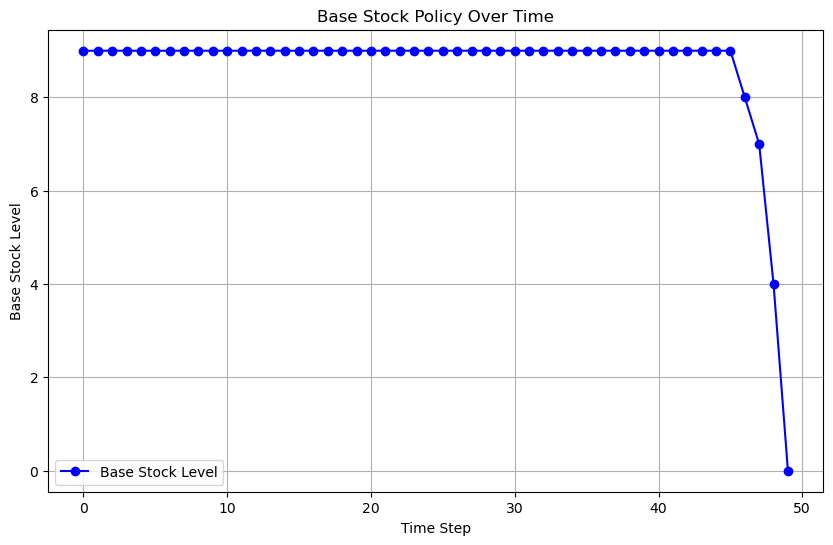

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def compute_base_stock_levels(V, time_steps, min_inventory, max_inventory, 
                              demand_values, demand_prob, holding_cost, discount, price, s=0):
    """
    Computes a single base-stock level sigma_t for each time step t for a given pre-decision state s.
    We solve:
      sigma_t = argmin_{z >= s} { price*(z-s) + H_t(z) },
    where H_t(z) = E[ h(z - W_t) + discount * V[t+1](z - W_t) ].
    """
    num_states = max_inventory - min_inventory + 1
    base_stocks = []

    for t in range(time_steps):
        H_t = np.zeros(num_states)
        
        # Compute H_t(z) for every feasible post-decision inventory level z.
        for zIndex in range(num_states):
            z = zIndex + min_inventory
            cost_sum = 0.0
            for w in demand_values:
                new_inventory = z - w
                new_inventory = max(min_inventory, min(new_inventory, max_inventory))
                new_index = new_inventory - min_inventory
                cost_sum += demand_prob * (holding_cost(new_inventory) + discount * V[t+1, new_index])
            H_t[zIndex] = cost_sum
        
        # Now, find sigma_t = argmin_{z >= s} { price*(z - s) + H_t(z) }.
        best_cost = float('inf')
        best_z = None
        for zIndex in range(num_states):
            z = zIndex + min_inventory
            if z >= s:
                order_cost = price * (z - s)
                total_cost = order_cost + H_t[zIndex]
                if total_cost < best_cost:
                    best_cost = total_cost
                    best_z = z
        base_stocks.append(best_z)
    return base_stocks

# Compute base-stock levels

demand_values = np.arange(0, 11)  # Possible demand values from 0 to 10
demand_prob = 1.0 / len(demand_values)  # Uniform probability distribution

base_stock_levels = compute_base_stock_levels(V, time_steps, min_inventory, max_inventory, 
                                              demand_values, demand_prob, holding_cost, discount, price)

# Plot the base-stock policy
plt.figure(figsize=(10, 6))
plt.plot(range(time_steps), base_stock_levels, marker='o', linestyle='-', color='blue', label='Base Stock Level')
plt.xlabel("Time Step")
plt.ylabel("Base Stock Level")
plt.title("Base Stock Policy Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
def simulate_and_print(env, policy, base_stock_levels, time_steps):
    """
    Simulate a single episode from t=0 to t=time_steps-1 using the given policy,
    starting at inventory = 0. Print:
      - current inventory
      - base-stock threshold
      - demand
      - action
    for each time step.
    
    Arguments:
      env: an environment-like object or parameters for min_inventory, max_inventory
      policy: a 2D array policy[t, s] giving the optimal action at time t and state s
      base_stock_levels: list/array of base-stock thresholds, one for each time step
      time_steps: the horizon length
    """
    # Start from inventory = 0
    current_inventory = 0
    current_state = current_inventory - env.min_inventory

    for t in range(time_steps):
        # Base-stock threshold for time t (already computed)
        threshold_t = base_stock_levels[t]

        # Sample random demand from [0..10]
        demand = np.random.randint(0, 11)

        # Action from the policy
        action = policy[t, current_state]

        # Print the desired info
        print(f"Time {t:2d} | Inventory = {current_inventory:4d} "
              f"| Base Stock = {threshold_t:4d} "
              f"| Demand = {demand:2d} "
              f"| Action = {action:2d}")

        # Update inventory
        new_inventory = current_inventory + action - demand
        new_inventory = max(env.min_inventory, min(new_inventory, env.max_inventory))

        # Move to the next state
        current_inventory = new_inventory
        current_state = current_inventory - env.min_inventory


# EXAMPLE USAGE AFTER YOUR VI CODE:
# ---------------------------------
# 1) Assume you've already run Value Iteration:
#    policy, V = vi.value_iteration()

# 2) Compute base-stock levels (if desired):
#    base_stock_levels = compute_base_stock_levels(...)

# 3) Simulate & print:
simulate_and_print(vi, policy, base_stock_levels, time_steps)


Time  0 | Inventory =    0 | Base Stock =    9 | Demand =  2 | Action =  9
Time  1 | Inventory =    7 | Base Stock =    9 | Demand =  0 | Action =  2
Time  2 | Inventory =    9 | Base Stock =    9 | Demand = 10 | Action =  0
Time  3 | Inventory =   -1 | Base Stock =    9 | Demand =  7 | Action = 10
Time  4 | Inventory =    2 | Base Stock =    9 | Demand =  6 | Action =  7
Time  5 | Inventory =    3 | Base Stock =    9 | Demand = 10 | Action =  6
Time  6 | Inventory =   -1 | Base Stock =    9 | Demand =  7 | Action = 10
Time  7 | Inventory =    2 | Base Stock =    9 | Demand =  5 | Action =  7
Time  8 | Inventory =    4 | Base Stock =    9 | Demand =  5 | Action =  5
Time  9 | Inventory =    4 | Base Stock =    9 | Demand =  6 | Action =  5
Time 10 | Inventory =    3 | Base Stock =    9 | Demand =  3 | Action =  6
Time 11 | Inventory =    6 | Base Stock =    9 | Demand =  8 | Action =  3
Time 12 | Inventory =    1 | Base Stock =    9 | Demand =  7 | Action =  8
Time 13 | Inventory =    

Time Step | Inventory | Base Stock Threshold | Demand | Action
---------------------------------------------------------------
        0 |         0 |                    9 |      6 |      9
        1 |         3 |                    9 |      8 |      6
        2 |         1 |                    9 |      6 |      8
        3 |         3 |                    9 |      0 |      6
        4 |         9 |                    9 |      9 |      0
        5 |         0 |                    9 |      2 |      9
        6 |         7 |                    9 |      7 |      2
        7 |         2 |                    9 |      3 |      7
        8 |         6 |                    9 |      9 |      3
        9 |         0 |                    9 |     10 |      9
       10 |        -1 |                    9 |      9 |     10
       11 |         0 |                    9 |      5 |      9
       12 |         4 |                    9 |      5 |      5
       13 |         4 |                    9 |      9 

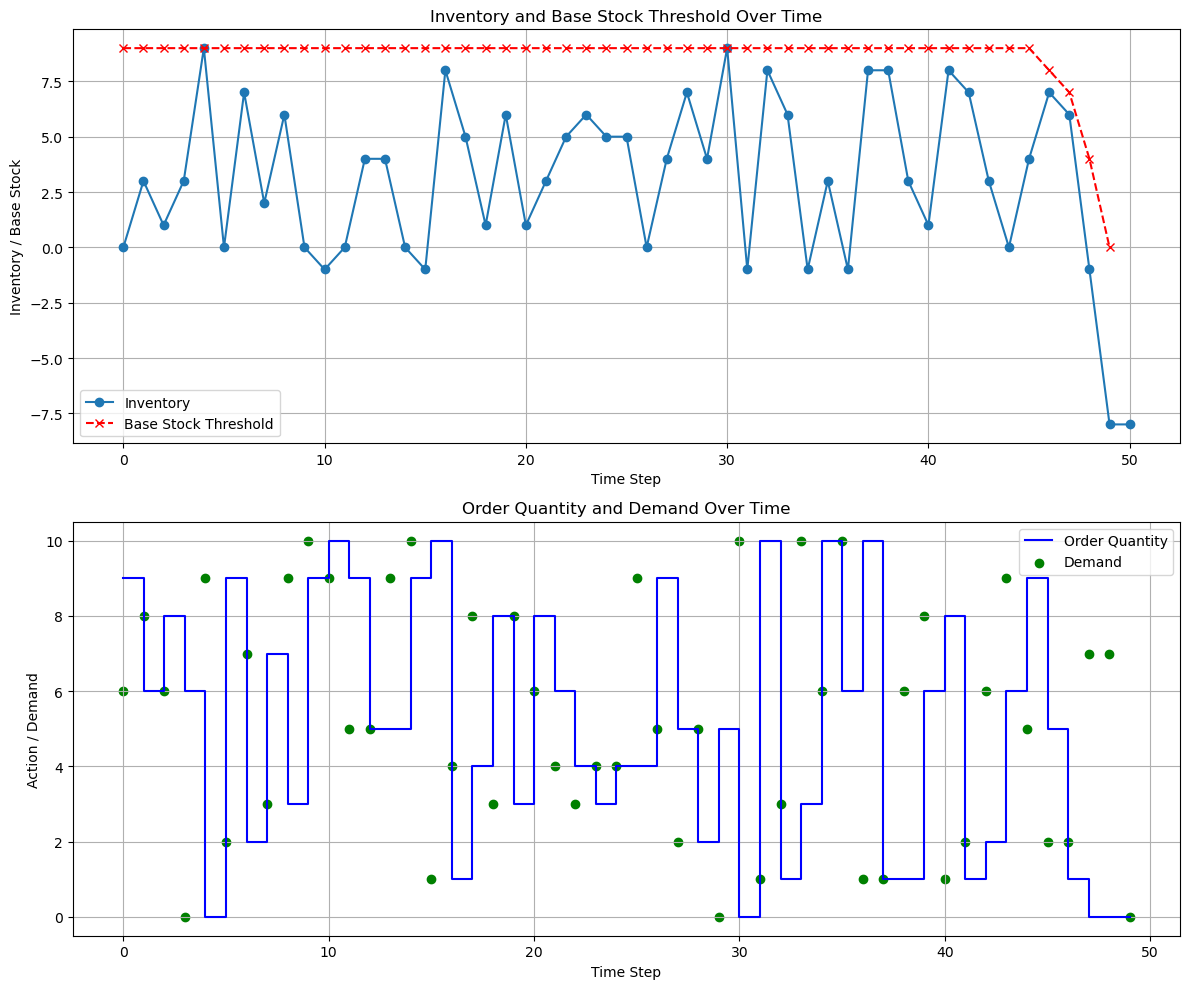

In [4]:
def simulate_and_print_and_plot(env, policy, base_stock_levels, time_steps):
    """
    Simulate a single episode from t=0 to t=time_steps-1 using the given policy,
    starting at inventory = 0. For each time step, print:
      - current inventory
      - base-stock threshold
      - demand
      - action
    Then, produce two plots:
      1. Inventory and base-stock threshold vs. time.
      2. Order quantity and demand vs. time.
    """
    # Start with inventory = 0.
    current_inventory = 0
    current_state = current_inventory - env.min_inventory  # state index corresponding to inventory 0
    
    # Initialize arrays to store simulation results for plotting.
    times = []
    inventories = []
    base_stocks = []
    actions_list = []
    demands = []
    
    print("Time Step | Inventory | Base Stock Threshold | Demand | Action")
    print("---------------------------------------------------------------")
    for t in range(time_steps):
        # Get the base-stock threshold for time step t.
        threshold_t = base_stock_levels[t]
        # Sample a random demand (or use an expected value if desired, e.g., 5 for U(0,10)).
        demand = np.random.randint(0, 11)
        # Choose the action from the policy at time t and current state.
        action = policy[t, current_state]
        
        # Print the current time step's results.
        print(f"{t:9d} | {current_inventory:9d} | {threshold_t:20d} | {demand:6d} | {action:6d}")
        
        # Store results for plotting.
        times.append(t)
        inventories.append(current_inventory)
        base_stocks.append(threshold_t)
        actions_list.append(action)
        demands.append(demand)
        
        # Update inventory: new_inventory = current_inventory + action - demand.
        new_inventory = current_inventory + action - demand
        new_inventory = max(env.min_inventory, min(new_inventory, env.max_inventory))
        
        # Update for next time step.
        current_inventory = new_inventory
        current_state = current_inventory - env.min_inventory

    # Append final time step for plotting the inventory trajectory.
    times.append(time_steps)
    inventories.append(current_inventory)
    
    # -----------------------------
    # Plotting the results:
    # -----------------------------
    plt.figure(figsize=(12, 10))
    
    # Subplot 1: Inventory trajectory and Base Stock Threshold over time.
    plt.subplot(2, 1, 1)
    plt.plot(times, inventories, marker='o', linestyle='-', label="Inventory")
    # Since base_stock_levels is computed for time steps 0 to time_steps-1, use times[:-1] for it.
    plt.plot(range(time_steps), base_stocks, marker='x', linestyle='--', color='red', label="Base Stock Threshold")
    plt.xlabel("Time Step")
    plt.ylabel("Inventory / Base Stock")
    plt.title("Inventory and Base Stock Threshold Over Time")
    plt.legend()
    plt.grid(True)
    
    # Subplot 2: Order Quantity (Action) and Demand over time.
    plt.subplot(2, 1, 2)
    plt.step(range(time_steps), actions_list, where='post', label="Order Quantity", color='blue')
    plt.scatter(range(time_steps), demands, label="Demand", color='green')
    plt.xlabel("Time Step")
    plt.ylabel("Action / Demand")
    plt.title("Order Quantity and Demand Over Time")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example usage (assuming you've already computed policy and base_stock_levels):
simulate_and_print_and_plot(vi, policy, base_stock_levels, time_steps)


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Assuming you already have the VI object (vi) and its value function V from your VI code.
# For example:
# vi = ValueIteration(num_states, actions, rewards, time_steps, discount, min_inventory, max_inventory)
# policy, V = vi.value_iteration()
#
# V is a numpy array of shape (time_steps+1, num_states)
# and the environment parameters are stored in vi.min_inventory, vi.max_inventory, etc.

# Define time_steps based on your VI solution.
time_steps = vi.ts  # which is 50 in your case

# Create an array of inventory levels corresponding to each state.
inventory_levels = np.arange(vi.min_inventory, vi.max_inventory+1)

# Create a directory to store frames (optional)
frame_dir = "frames"
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)

filenames = []
for t in range(time_steps + 1):
    plt.figure(figsize=(10, 6))
    plt.plot(inventory_levels, V[t, :], marker='o', linestyle='-', color='purple')
    plt.xlabel("Inventory Level")
    plt.ylabel("Value Function")
    plt.title(f"Value Function at Time Step {t}")
    plt.grid(True)
    # Save the current figure as an image file.
    filename = os.path.join(frame_dir, f"frame_{t:03d}.png")
    plt.savefig(filename)
    plt.close()
    filenames.append(filename)

# Create a GIF from the saved frames.
gif_filename = "value_function.gif"
with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Optionally, clean up the temporary image files.
for filename in filenames:
    os.remove(filename)
os.rmdir(frame_dir)

print(f"GIF saved as '{gif_filename}'.")


/tmp/ipykernel_6713/3470572800.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as 'value_function.gif'.


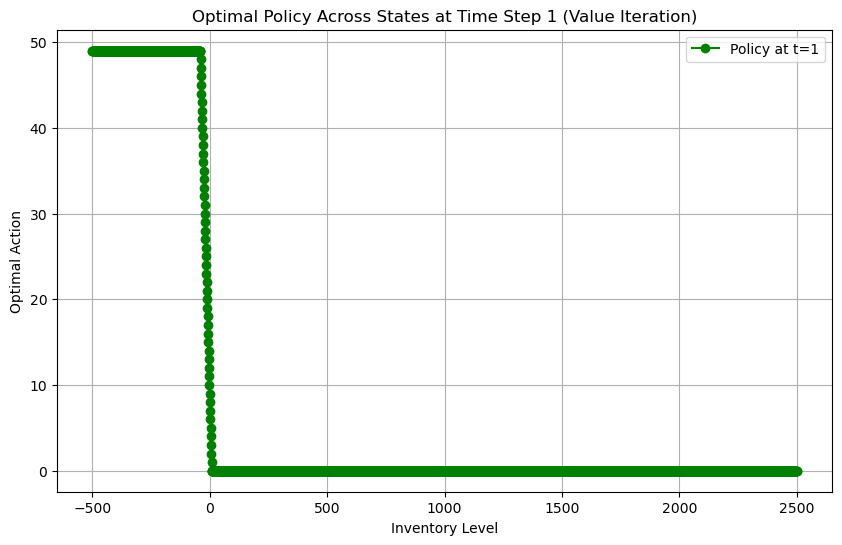

In [ ]:

# Choose a time step to inspect (e.g., t = 1)
time_step_to_plot = 1  # Change as desired

# Generate x-values corresponding to the inventory levels.
# Since states are indexed from 0 to num_states-1,
# the inventory level for state i is: i + min_inventory.
x_values = np.arange(vi.min_inventory, vi.min_inventory + num_states)

plt.figure(figsize=(10, 6))
plt.plot(x_values, policy[time_step_to_plot, :], marker='o', linestyle='-', color='green',
         label=f'Policy at t={time_step_to_plot}')
plt.xlabel("Inventory Level")
plt.ylabel("Optimal Action")
plt.title(f"Optimal Policy Across States at Time Step {time_step_to_plot} (Value Iteration)")
plt.legend()
plt.grid(True)
plt.show()


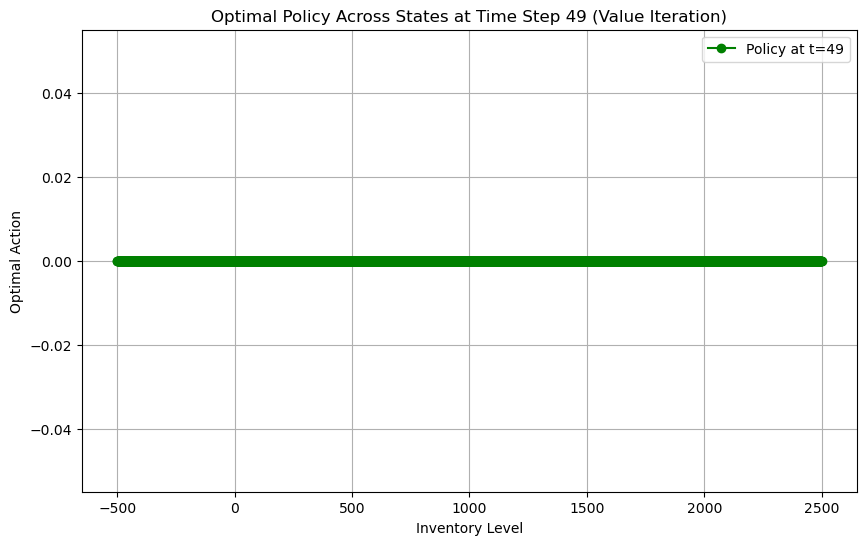

In [7]:

# Choose a time step to inspect (e.g., t = 1)
time_step_to_plot = 49  # Change as desired

# Generate x-values corresponding to the inventory levels.
# Since states are indexed from 0 to num_states-1,
# the inventory level for state i is: i + min_inventory.
x_values = np.arange(vi.min_inventory, vi.min_inventory + num_states)

plt.figure(figsize=(10, 6))
plt.plot(x_values, policy[time_step_to_plot, :], marker='o', linestyle='-', color='green',
         label=f'Policy at t={time_step_to_plot}')
plt.xlabel("Inventory Level")
plt.ylabel("Optimal Action")
plt.title(f"Optimal Policy Across States at Time Step {time_step_to_plot} (Value Iteration)")
plt.legend()
plt.grid(True)
plt.show()